In [153]:
!git clone https://omarabbas3210@bitbucket.org/jadslim/german-traffic-signs.git

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [154]:
!ls german-traffic-signs/

signnames.csv  test.p  train.p	valid.p


In [155]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import Input
import pickle
import random
import pandas as pd
import cv2
import requests
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [156]:
np.random.seed(0)

In [157]:
with open("german-traffic-signs/train.p", "rb") as f:
  train_data = pickle.load(f)
with open("german-traffic-signs/test.p", "rb") as f:
  test_data = pickle.load(f)
with open("german-traffic-signs/valid.p", "rb") as f:
  val_data = pickle.load(f)

print(type(train_data))

<class 'dict'>


In [158]:
x_train = train_data["features"]
y_train = train_data["labels"]
x_test  = test_data["features"]
y_test  = test_data["labels"]
x_val   = val_data["features"]
y_val   = val_data["labels"]

In [159]:
x_train.shape


(34799, 32, 32, 3)

In [160]:
assert(len(x_train)== len(y_train)), "training images and labels are not of same number"
assert(len(x_test)== len(y_test)), "validation images and labels are not of same number"
assert(len(x_val)== len(y_val)), "testing images and labels are not of same number"
assert(x_train.shape[1:]==(32,32,3)) ,"error in image size (training)"
assert(x_test.shape[1:]==(32,32,3)), "error in image size (testing)"
assert(x_val.shape[1:]==(32,32,3)), "error in image size (validation)"


#Notice how we asure the size of images by using shape function



In [161]:
data = pd.read_csv("german-traffic-signs/signnames.csv")
print((data["SignName"]))

0                                  Speed limit (20km/h)
1                                  Speed limit (30km/h)
2                                  Speed limit (50km/h)
3                                  Speed limit (60km/h)
4                                  Speed limit (70km/h)
5                                  Speed limit (80km/h)
6                           End of speed limit (80km/h)
7                                 Speed limit (100km/h)
8                                 Speed limit (120km/h)
9                                            No passing
10         No passing for vechiles over 3.5 metric tons
11                Right-of-way at the next intersection
12                                        Priority road
13                                                Yield
14                                                 Stop
15                                          No vechiles
16             Vechiles over 3.5 metric tons prohibited
17                                             N

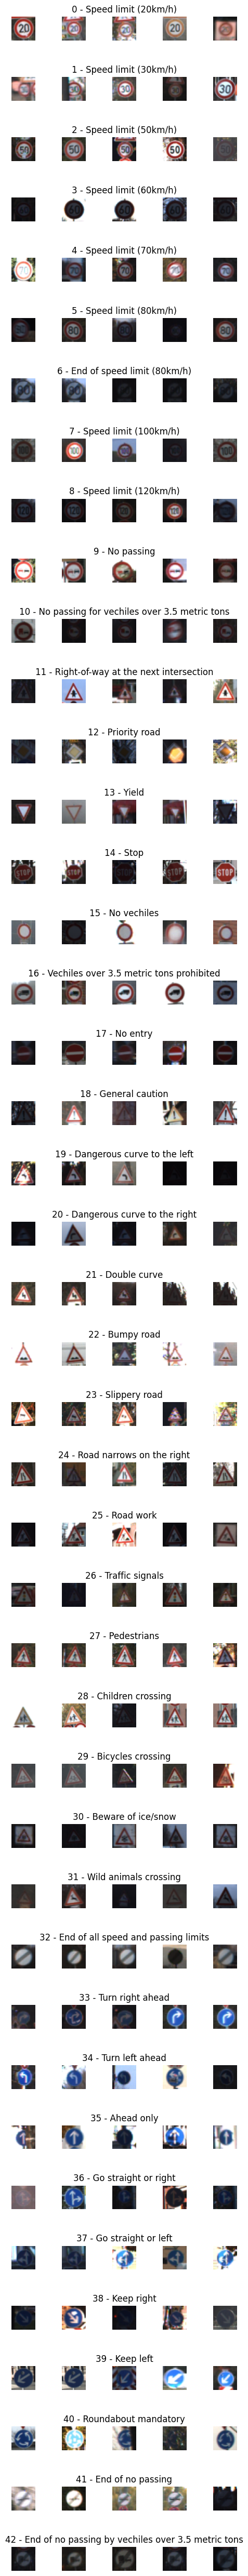

In [162]:


data_chart = []

rows =43
cols = 5


fig, axis = plt.subplots(rows,cols, figsize = (5,50)) #first is number of rows, sec is number of columns, third is fig size and if left blank would be set to default which is small
fig.tight_layout()

for i, row in data.iterrows() :
  for j in range(cols):
    x_selected = x_train[y_train==i, :,:,:]
    axis[i][j].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :,:], cmap = plt.get_cmap('gray'))
    axis[i][j].axis("off")
    if j == 2:
      axis[i][j].set_title(str(i)+ " - " + row["SignName"])
      data_chart.append(len(x_selected))




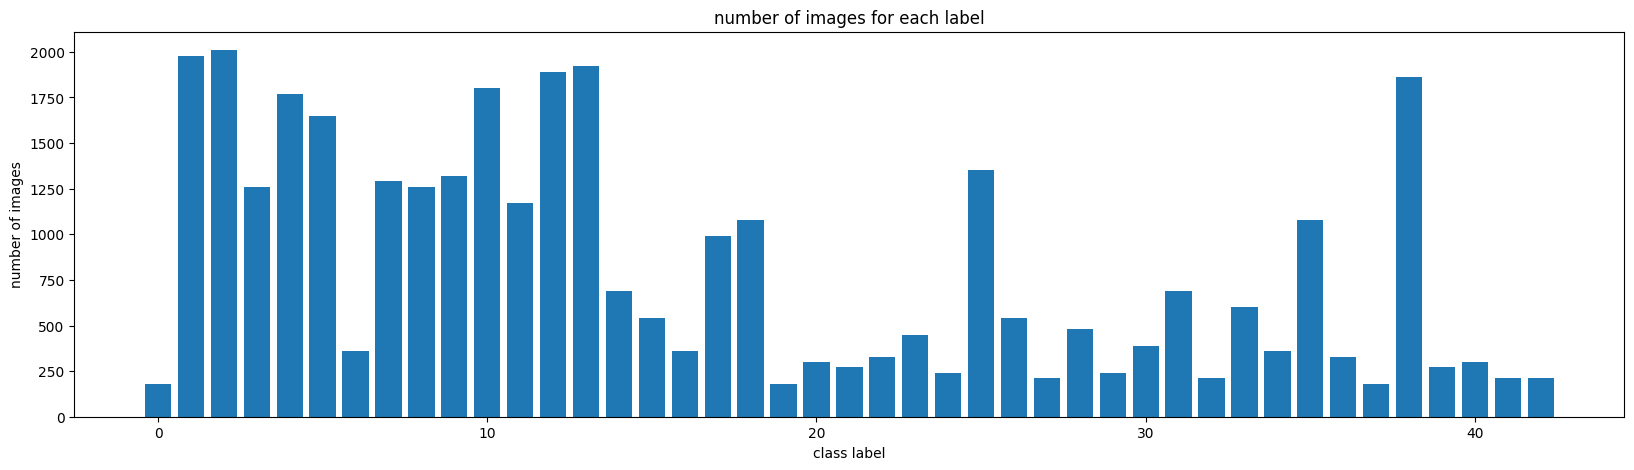

In [163]:
plt.figure(figsize = (20,5))
x_axis = []
for i in range(len(data_chart)):
  x_axis.append(i)

plt.bar(x_axis, data_chart)
plt.xlabel("class label")
plt.ylabel("number of images")
plt.title("number of images for each label")
plt.show()

In [164]:
def preproccess_img(img):
  img  =  cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = img.reshape(32,32,1)
  img = cv2.equalizeHist(img)
  img = img/255
  return img

In [165]:
x_train = np.array(list(map(preproccess_img,x_train )))
x_test = np.array(list(map(preproccess_img,x_test )))
x_val = np.array(list(map(preproccess_img,x_val )))




In [166]:
x_train = x_train.reshape(len(x_train) ,32,32,1)
x_test = x_test.reshape(len(x_test) ,32,32,1)
x_val = x_val.reshape(len(x_val) ,32,32,1)

x_train.shape


(34799, 32, 32, 1)

In [167]:
datagen = ImageDataGenerator(width_shift_range=.1,
                             height_shift_range =.1,
                             zoom_range = 0.2,
                             shear_range = 0.1,
                             rotation_range = 10.
                             )

datagen.fit(x_train)


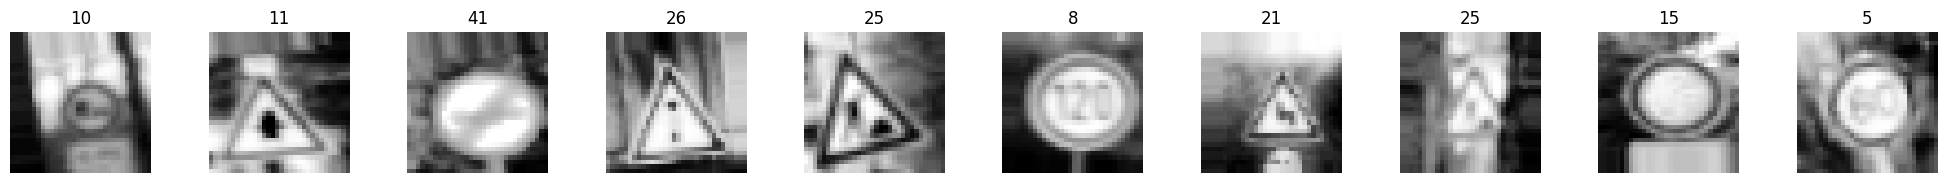

In [168]:
batches = datagen.flow(x_train, y_train, batch_size= 15)

x_batch , y_batch = next(batches)

fig ,axis = plt.subplots(1 ,10, figsize = (20,10))
fig.tight_layout()

for i in range(10):
  axis[i].imshow(x_batch[i], cmap = plt.get_cmap("gray"))
  axis[i].set_title(y_batch[i])
  axis[i].axis("off")


In [169]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [170]:
model = Sequential()
model.add(Input(  (32,32,1)))
model.add(Conv2D(90, kernel_size=(5,5), activation= 'relu'))
model.add(Conv2D(90, kernel_size=(5,5), activation= 'relu'))
#model.add(Dropout(.5))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(30, kernel_size=(3,3), activation='relu' ))
model.add(Conv2D(30, kernel_size=(3,3), activation='relu' ))
#model.add(Dropout(.5))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(43, activation='softmax'))
model.compile(Adam(learning_rate=(.001)), loss = 'categorical_crossentropy', metrics = ["accuracy"]  )

In [171]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 28, 28, 90)          │           2,340 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 24, 24, 90)          │         202,590 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 12, 12, 90)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 10, 10, 30)          │          24,330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 8, 8, 30)            │           8,130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 4, 4, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 500)                 │         240,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 43)                  │          21,543 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 499,433 (1.91 MB)

 Trainable params: 499,433 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [172]:
h = model.fit(datagen.flow(x_train, y_train, batch_size=50), steps_per_epoch = 2000, epochs =18, validation_data = (x_val, y_val) , shuffle = 1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/18
 694/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - accuracy: 0.3052 - loss: 2.5605

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - accuracy: 0.4462 - loss: 1.9996 - val_accuracy: 0.9095 - val_loss: 0.2875
Epoch 2/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8264 - loss: 0.5685 - val_accuracy: 0.9558 - val_loss: 0.1341
Epoch 3/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.8924 - loss: 0.3485 - val_accuracy: 0.9551 - val_loss: 0.1205
Epoch 4/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9176 - loss: 0.2638 - val_accuracy: 0.9735 - val_loss: 0.0796
Epoch 5/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9339 - loss: 0.2131 - val_accuracy: 0.9755 - val_loss: 0.0739
Epoch 6/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9449 - loss: 0.1773 - val_accuracy: 0.9825 - val_loss: 0.0573
Epoch 7/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9516 - loss: 0.1546 - val_accuracy: 0.9866 - val_loss: 0.0458
Epoch 8/18
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9561 - loss: 0.1443 - val

Text(0.5, 1.0, 'accuracy')

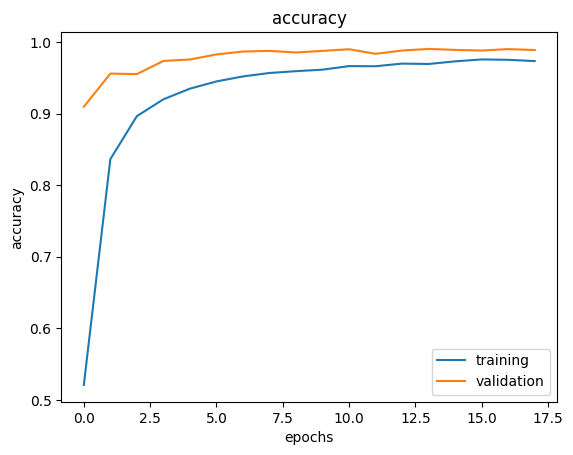

In [173]:
plt.plot(h.history["accuracy"])
plt.plot(h.history["val_accuracy"])
plt.legend(["training", "validation"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("accuracy")

Text(0.5, 1.0, 'loss')

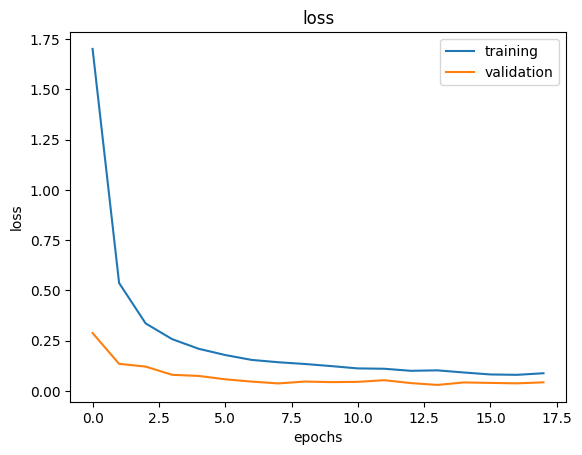

In [174]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.legend(["training", "validation"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("loss")

In [175]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9750 - loss: 0.0987
Test score: 0.10006078332662582
Test accuracy: 0.9760887026786804


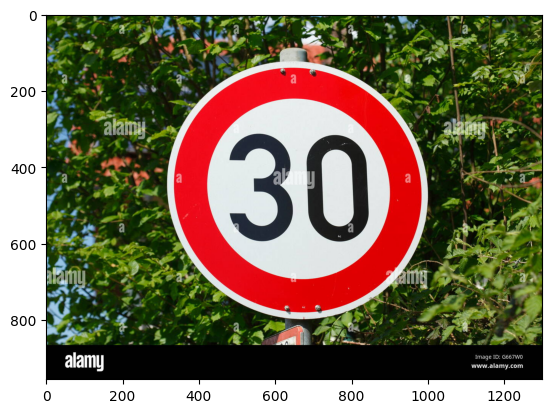

In [218]:
url ="https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"
r = requests.get(url, stream =True)
img  = Image.open(r.raw)
plt.imshow(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


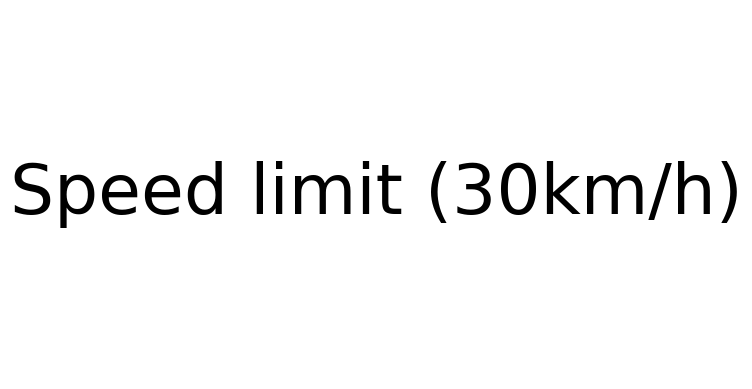

In [219]:
img = np.asarray(img)
img = cv2.resize(img, (32,32))
img = preproccess_img(img)
img  = img.reshape(1,32,32,1)


index = np.argmax(model.predict(img))

text = data.loc[index, "SignName"]


plt.text(0.5, 0.5, text, fontsize=50, ha='center', va='center')
plt.axis('off')  # Hide axes
plt.show()



#6Hello
